In [417]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import warnings
from sklearn.linear_model import LogisticRegression
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
import seaborn as sn
import pandas as pd 

import tensorflow as tf
from tensorflow import keras


In [418]:
# We need to store cropped face images in cropped folder
# Face detection using Haar cascades is a machine learning based approach where a cascade function is trained with a set of input data
# The detection works only on grayscale images
# Faces contains a list of coordinates for the rectangular regions where faces were found. 
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier("./opencv/haarcascades/haarcascade_eye.xml")
#save the image(i) in the same directory
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if(img is not None):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color   
    else:
        exit(1)

In [419]:
# Get the paths of original images

path_to_data = "./Data/"
path_to_cr_data = "./Data/cropped/"

import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        if(entry.path!='./Data/.ipynb_checkpoints' and entry.path!='./Data/cropped'):
            img_dirs.append(entry.path)
        
img_dirs

['./Data/SW', './Data/MS', './Data/RF']

In [420]:
# Remove smaller face images folder if it already exists, else make a new one

import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [421]:
# Store cropped face images in cropped folder

cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./Data/cropped/SW
Generating cropped images in folder:  ./Data/cropped/MS
Generating cropped images in folder:  ./Data/cropped/RF


In [422]:
# Wavelet transform of images

import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H


In [423]:
# # Example wavelet transform for MS Dhoni Image

# img = cv2.imread('./Data/MSD/MSD.jpg')
# plt.imshow(img)


In [424]:
# roi_color=get_cropped_image_if_2_eyes('./Data/MSD/MSD.jpg')
# plt.imshow(roi_color, cmap='gray')


In [425]:
# cropped_img = np.array(roi_color)
# im_har = w2d(cropped_img,'db1',5)
# plt.imshow(im_har, cmap='gray')

In [426]:
# Making one image containing original cut image and wavelet transformed image and adding it to X
# 

X=[]
y=[]
classdict={}
count=0

for celebrity,training_images in celebrity_file_names_dict.items():
    classdict[celebrity]=count
    count=count+1

for celebrity,training_images in celebrity_file_names_dict.items():
    for image in training_images:
        img=cv2.imread(image)
        if img is None:
            print('No Image')
            continue
        scaled_raw_img=cv2.resize(img,(32,32))
        im_har = w2d(img,'db1',5)
        scaled_img_har=cv2.resize(im_har,(32,32))
        combined_img=np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(classdict[celebrity])
X=np.array(X).reshape(len(X),4096).astype(float)
y=np.array(y).reshape(len(y),1).astype(float)

Precision is 0.8903318903318903
Recall is 0.9
Accuracy is 0.8918918918918919
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90        15
         1.0       0.91      0.83      0.87        12
         2.0       0.83      1.00      0.91        10

    accuracy                           0.89        37
   macro avg       0.89      0.90      0.89        37
weighted avg       0.90      0.89      0.89        37



Text(33.0, 0.5, 'Actual')

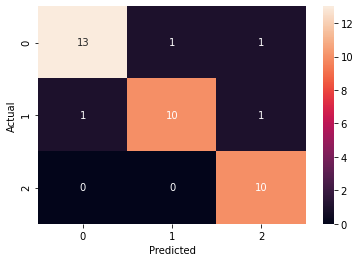

In [427]:
df=pd.DataFrame(X)
df['Celebrity']=y

X=df.drop('Celebrity',axis='columns')
y=df['Celebrity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

logisticRegression=LogisticRegression()
logisticRegression.fit(X_train,y_train)
y_pred=logisticRegression.predict(X_test)
print("Precision is {}".format(sklearn.metrics.precision_score(y_test, y_pred, average = "macro")))
print("Recall is {}".format(sklearn.metrics.recall_score(y_test, y_pred, average = "macro")))
print("Accuracy is {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(classification_report(y_test,y_pred))
sn.heatmap(tf.math.confusion_matrix(labels=y_test, predictions=y_pred),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")



Accuracy is 0.8918918918918919
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93        15
         1.0       0.90      0.75      0.82        12
         2.0       0.83      1.00      0.91        10

    accuracy                           0.89        37
   macro avg       0.89      0.89      0.89        37
weighted avg       0.90      0.89      0.89        37



Text(33.0, 0.5, 'Actual')

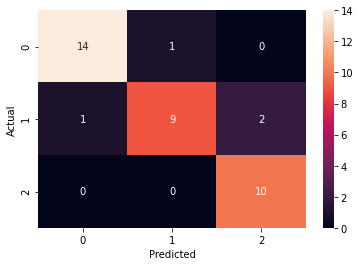

In [428]:
# Recall for class 1 is how many cases out of total were you able to predict for class 1. 
# Thinking about cancer, let's say 20 had cancer and you predicted 19 out of them correctly. 
# Recall is 95%


# Precision for class 1 is How many you predicted class 1/How many actually are class 1. 
# Thinking about cancer, you predicted 100 mights have cancer and 20 of them actually had cancer
# Precision is 20% 

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])
pipe.fit(X_train,y_train)
print("Accuracy is {}".format(pipe.score(X_test,y_test)))
print(classification_report(y_test,pipe.predict(X_test)))
y_pred=pipe.predict(X_test)
sn.heatmap(tf.math.confusion_matrix(labels=y_test, predictions=y_pred),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [429]:
# GridSearchCV can try multiple algorithms and multiple hyperparameters
# GrisSearch CV uses part of train set as validation set in order to find the best hyperparameter

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.840887,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
1,random_forest,0.798768,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.820197,{'logisticregression__C': 1}


In [440]:
# Just trying svm on test set as well
best_clf= best_estimators['svm']
best_estimators['svm'].score(X_test,y_test)

0.8918918918918919

In [441]:
# Saving the model 
import joblib
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [443]:
#Save dictionary
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(classdict))